### imports

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, precision_score, accuracy_score, recall_score, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## Data cleaning

<hr style="border: 2px solid #95e89e">

### I. filtering data to selected observation (top 20%)

#### what happens in these next 2 blocks of codes:

- importing datasets
- limiting the store dataset, `Rossmann_store.csv` to just the top 20% of stores in terms of sales
    - done by: calc avg sales for each store, then take top 20% of stores in terms of sales
- similarly, we wanna limit the other dataset we will use, `Rossmann_train.csv` so that it only gives us details of the top 20% sales stores
    - done by: filtering by the Store IDs based on those present in our t20 store df obtained earlier


<i>use this:</i>

In [20]:
# importing datasets
rossmann_store = pd.read_csv("Rossmann_store.csv")
rossmann_sales = pd.read_csv("Rossmann_train.csv") # from here on the train dataset will be referred to as the sales dataset

<i>followed by this:</i>

In [22]:
# creating a function to calculate the average sales for a store
def calc_avg_sales(store_id: int)-> float:
    """This function takes a store ID and returns the average sales value for that store."""
    a_store = rossmann_sales.loc[ (rossmann_sales['Store'] == store_id) ]
    avg_sales = a_store['Sales'].mean()
    return avg_sales.round(2)

# calculating and recording the average sales for each store
store_avg_sales = []
for i in range(1,1116):
    store_avg_sales.append(calc_avg_sales(i))

# adding the average sales data for each store into the store dataset
rossmann_store_w_avg = pd.concat([rossmann_store, pd.DataFrame({'AverageSales' : store_avg_sales})], axis=1)

# taking the top 20 percent of stores in terms of sales
rossmann_store_t20 = \
rossmann_store_w_avg.loc[ (rossmann_store_w_avg['AverageSales'] >= rossmann_store_w_avg['AverageSales'].quantile(0.8)) ]

# filtering the sales dataset
rossmann_sales_t20 = rossmann_sales.loc[ rossmann_sales['Store'].isin(rossmann_store_t20['Store']) ]

<hr style="border: 2px solid #73deb0">

### II. merging datasets & imputation of missing values for Promo2-related columns

#### what happens in this next block of code (done with method chaining):
- merged datasets
- convert `Date` dtype to datetime
- to reduce confusion, renamed `PromoInterval` to `Promo2Interval` since it's referring to Promo2

- filled in missing values for `Promo2SinceWeek`, `Promo2SinceYear`, and `Promo2Interval`
    - `Promo2SinceWeek`, `Promo2SinceYear` : replaced NaN with <b>0</b> if `Promo2` == 0
    - `Promo2Interval` : replaced NaN with <b>NA</b> (= Not Applicable) if `Promo2` == 0

- created a new column with category codes: `Promo2IntervalCat`
    - category <b>0</b> is <b>NA</b>
    - category <b>1</b> is <b>Jan,Apr,Jul,Oct</b>
    - category <b>2</b> is <b>Feb,May,Aug,Nov</b>
    - category <b>3</b> is <b>Mar,Jun,Sept,Dec</b>


<i>continue from previous section, now use this:</i>

In [23]:
rossmann = (
    pd.merge(rossmann_store_t20, rossmann_sales_t20, on='Store', how='right')   # merging the filtered datasets
    .assign(Date = lambda df: pd.to_datetime(df['Date']))                       # converting Date dtype from to datetime
    .rename(columns={'PromoInterval':'Promo2Interval'})                           # renaming PromoInterval to Promo2Interval
    .fillna({'Promo2SinceWeek':0,'Promo2SinceYear':0,'Promo2Interval':'NA'})  # filling in some missing values
    
    # creating a new column to categorize Promo2Interval
    .assign(Promo2IntervalCat = lambda df: df['Promo2Interval']
            .astype('category')
           )
    
    # changing categories to categorical codes for the new column
    .assign(Promo2IntervalCat = lambda df: pd.Categorical(df['Promo2IntervalCat'], categories= \
                                                          ['NA','Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec'])
            .codes
           )
    
    .set_index('Date')   # setting the Date as our index
)

In [26]:
rossmann.isna().sum()

Store                            0
StoreType                        0
Assortment                       0
CompetitionDistance              0
CompetitionOpenSinceMonth    57874
CompetitionOpenSinceYear     57874
Promo2                           0
Promo2SinceWeek                  0
Promo2SinceYear                  0
Promo2Interval                   0
AverageSales                     0
DayOfWeek                        0
Sales                            0
Customers                        0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
Promo2IntervalCat                0
dtype: int64

* We observe missing values only exists in `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear` columns.

<hr style="border: 2px solid #73deb0">

### III. Imputation for continuous data

#### What happens in this next block of code:
- Note that `pipe` method is used as there are multiple data processing functions to call for readability and clarity of code.<br><br>

- **Preliminary Analysis** 
    - setting up **k-Nearest Neighbours** model to observe test scores for different imputation methods
    - test scores includes `accuracy`, `precision` and `recall`.
    - Investigate the most suitable k value to be used in the KNN model using the `elbow method`
<br>

- **Simple imputation**
    - **Mean** and **Median** imputation is used
    - **Testing scores** are computed
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **KNN imputation**
    - try `KNeighborsRegressor` using normalized data
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Linear Regression Imputation**
    - Plot `heatmap` to investigate correlation between variables
    - Use the `IterativeImputer` to impute missing data between the imputation columns and columns with the highest correlation with imputation columns
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Forest Imputation**
    - Use the combination fo `IterativeImputer` and `RandomForestRegressor` to impute missing values.
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Imputation Conclusion**
    - Concluding imputation findings.
    - Choose the best way of imputation

<hr>


#### **Preliminary Analysis**

* Setting up **k-Nearest Neighbours model**

In [28]:
def kNN_model(df,feature_columns, target, n):
    Xf = df[feature_columns]
    Yf = df[[target]]
    
    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=0)
    kNN = KNeighborsClassifier(n_neighbors=n)
    kNN.fit(X_train, Y_train.values.ravel())  # fit the data to the model
    Y_pred = kNN.predict(X_test)  # Predict the target values from the test feature data

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='binary' if len(Yf[target].unique()) == 2 else 'weighted')
    rec = recall_score(Y_test, Y_pred, average='binary' if len(Yf[target].unique()) == 2 else 'weighted')
    
    print("\n")
    print(f'Testing scores: accuracy {acc:.3f}, precision {prec:.3f}, recall {rec:.3f}')

* Find the n-neighbors for k-Nearest Neighbours using the elbow method

In [30]:
# keep first (may use later)

def elbow_method_knn(df, feature_columns, target, max_k=40, test_size=0.2, random_state=14):
    # Separate features and target
    Xf = df[feature_columns]
    Yf = df[target]

    # Ensure features and target are aligned
    Xf, Yf = Xf.align(Yf, join='inner', axis=0)
    
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=test_size, random_state=random_state)
    
    error_rate = []

    # Loop through different k values to find the optimal one
    for i in range(1, max_k):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred_i = knn.predict(X_test)
        # Calculate error rate as the proportion of misclassified samples
        error_rate.append(np.mean(pred_i != Y_test))
    
    # Plotting the Mean Absolute Deviation vs. Number of Neighbors
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_k), error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Mean Absolute Deviation vs. Number of Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Error Rate vs. K Value')
    plt.grid(True)
    plt.show()
    
    # Find the optimal number of neighbors
    k = np.argmin(error_rate) + 1
    return k

#optimal_k = elbow_method_knn(rossmann_mean_impute, feature_columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], target='Sales')
#print(f"Optimal number of neighbors for k-NN: {optimal_k}")


[[26  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]]


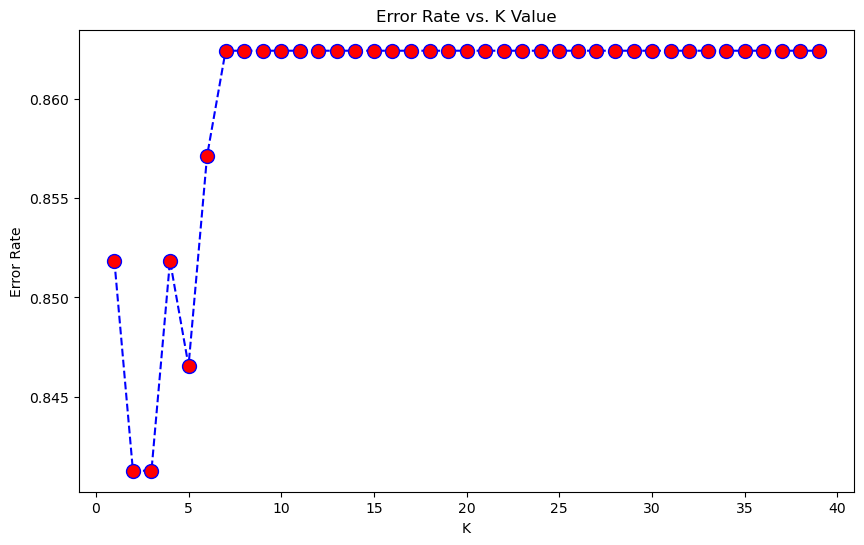

In [71]:
Xf = rossmann[rossmann.select_dtypes(['int','float']).columns.to_list()].dropna().drop_duplicates()
Yf = rossmann['Sales']

Xf = Xf.loc[~Xf.index.duplicated(keep='first')]
Yf = Yf.loc[~Yf.index.duplicated(keep='first')]

# Align Xf and Yf to ensure they have the same indices
Xf, Yf = Xf.align(Yf, join='inner', axis=0)
Xf, Yf = Xf.align(Yf, join='inner', axis=0)


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=13)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,Y_train)
pred = knn.predict(X_test)
print(confusion_matrix(Y_test,pred))


error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

* As shown in the error rate plot above, the optimal k value will be **k=1**

#### **Simple imputation**

##### Mean Inputation Functions

In [32]:
def impute_mean(df):
    df_mean = df.copy()
    df_mean.fillna(df_mean.mean(),inplace=True)
    return df_mean

    
rossmann_mean_impute = impute_mean(rossmann[rossmann.select_dtypes(['int','float']).columns.to_list()])


Print the testing scores out:

In [34]:
print("Imputation using mean")
kNN_model(rossmann_mean_impute,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)

Imputation using mean


Testing scores: accuracy 0.638, precision 0.680, recall 0.638


##### Median Inputation Functions

In [35]:
def impute_median(df):
    df_median = df.copy()
    df_median.fillna(df_median.median(),inplace=True)
    return df_median


rossmann_median_impute = impute_median(rossmann[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales']])

Print the testing scores out:

In [38]:
print("Imputation using median")
kNN_model(rossmann_median_impute,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)

Imputation using median


Testing scores: accuracy 0.640, precision 0.682, recall 0.640


##### Histogram plot 

* plot histogram to observe the appropriateness of imputation using mean and median

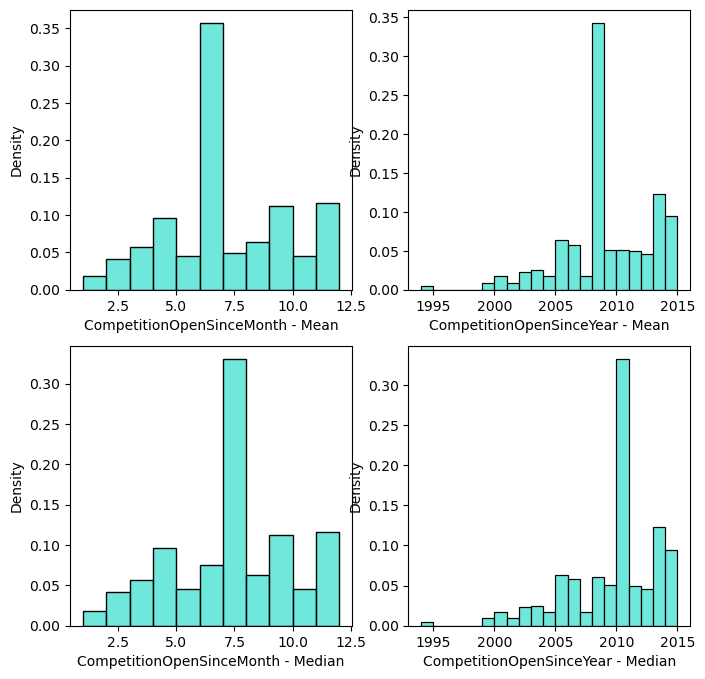

In [40]:
fig, axes = plt.subplots(2,2,figsize=(8, 8))

sns.histplot(rossmann_mean_impute, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0, 0])
axes[0, 0].set_xlabel('CompetitionOpenSinceMonth - Mean')

sns.histplot(rossmann_median_impute, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[1, 0])
axes[1, 0].set_xlabel('CompetitionOpenSinceMonth - Median')

sns.histplot(rossmann_mean_impute, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[0, 1])
axes[0, 1].set_xlabel('CompetitionOpenSinceYear - Mean')

sns.histplot(rossmann_median_impute, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1, 1])
axes[1, 1].set_xlabel('CompetitionOpenSinceYear - Median');

<hr>

**Observations**

- By observing the histogram, we observe a **peak** value which differs a lot with other values for both the **mean and median plot** <br>
- This indicates that mean and median imputation may not be a suitable way to impute the missing data in `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` column.

<hr>

#### **Knn imputation (Using KNeighborsRegressor)**

In [42]:
knn2 = rossmann.select_dtypes(include=['int', 'float']).copy()
filtered_rm = knn2.dropna(subset=['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'])

# Prepare data for training and testing
X = filtered_rm[['CompetitionDistance','Promo2']]
y_year = filtered_rm['CompetitionOpenSinceYear']
y_month = filtered_rm['CompetitionOpenSinceMonth']


X_train, X_test, y_train_year, y_test_year = train_test_split(X, y_year, test_size=0.2, random_state=1)
X_train, X_test, y_train_month, y_test_month = train_test_split(X, y_month, test_size=0.2, random_state=1)

# Train the k-NN models
knn_m_year = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_m_month = KNeighborsRegressor(n_neighbors=3, weights='distance')

model_year = knn_m_year.fit(X_train, y_train_year)
model_month = knn_m_month.fit(X_train, y_train_month)

# Find missing values
missing_year = knn2['CompetitionOpenSinceYear'].isnull()
missing_month = knn2['CompetitionOpenSinceMonth'].isnull()

df_missing_year = knn2[['CompetitionDistance','Promo2']][missing_year]
df_missing_month = knn2[['CompetitionDistance','Promo2']][missing_month]

# Predict and impute missing values
year_impute = model_year.predict(df_missing_year)
month_impute = model_month.predict(df_missing_month)

# Create another data set copy to prevent original DataFrame modification
rm_imputed = knn2.copy()

# Impute the predicted values 
rm_imputed.loc[missing_year, 'CompetitionOpenSinceYear'] = year_impute
rm_imputed.loc[missing_month, 'CompetitionOpenSinceMonth'] = month_impute

rossmann_cat = rossmann.select_dtypes(include=['int8', 'object']).copy()
rm_imputed = pd.concat([rm_imputed, rossmann_cat], axis=1)

# Evaluate model
'''
y_pred_test_year = model_year.predict(X_test)
mse_year = mean_squared_error(y_test_year, y_pred_test_year)
r2_year = r2_score(y_test_year, y_pred_test_year)


y_pred_test_month = model_month.predict(X_test)
mse_month = mean_squared_error(y_test_month, y_pred_test_month)
r2_month = r2_score(y_test_month, y_pred_test_month)

print('Year - Mean Squared Error:', mse_year)
print('Year - R^2 Score:', r2_year)
print('Month - Mean Squared Error:', mse_month)
print('Month - R^2 Score:', r2_month)

#rkm_imputed.isna().sum()'''

"\ny_pred_test_year = model_year.predict(X_test)\nmse_year = mean_squared_error(y_test_year, y_pred_test_year)\nr2_year = r2_score(y_test_year, y_pred_test_year)\n\n\ny_pred_test_month = model_month.predict(X_test)\nmse_month = mean_squared_error(y_test_month, y_pred_test_month)\nr2_month = r2_score(y_test_month, y_pred_test_month)\n\nprint('Year - Mean Squared Error:', mse_year)\nprint('Year - R^2 Score:', r2_year)\nprint('Month - Mean Squared Error:', mse_month)\nprint('Month - R^2 Score:', r2_month)\n\n#rkm_imputed.isna().sum()"

In [44]:
kNN_model(rm_imputed,['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.559, precision 0.601, recall 0.559


<hr>

* Plot historgram

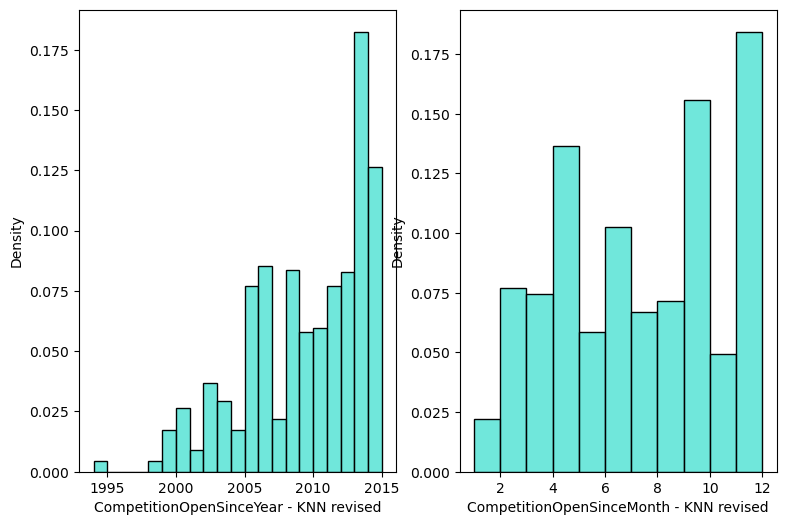

In [45]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(rm_imputed, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[0].set_xlabel('CompetitionOpenSinceYear - KNN revised')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(rm_imputed, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[1].set_xlabel('CompetitionOpenSinceMonth - KNN revised');

<hr>

**Observations:**

* `CompetitionOpenSinceYear` column
    * We observe a **bell shape curve** for inputation of `CompetitionOpenSinceYear` using the `KNN imputation` method.
    * This suggests that `KNN imputation` is most likely approriate to impute the missing values in `CompetitionOpenSinceYear`

* `CompetitionOpenSinceMonth` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.


<hr>

#### **Linear Regression Imputation**

##### Heat map

* To perform the linear regression imputation, we first have to investigate the feature columns that have the **highest correlation** with the columns that will be imputed.
* This will means that we are using `heatmap` to investigate the correlation between variables.

In [48]:
corr=rossmann.select_dtypes(include=['int','float']).corr()
corr.style.background_gradient(cmap='coolwarm')

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,AverageSales,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.020639,-0.048537,0.078079,-0.035265,0.015268,-0.035197,0.006755,0.000013,0.002910,0.012172,0.000416,-0.000074,-0.001014
CompetitionDistance,-0.020639,1.000000,-0.118109,-0.055882,-0.013439,-0.007115,-0.013575,-0.206142,-0.000014,-0.088812,-0.190187,0.009070,0.000081,-0.006431
CompetitionOpenSinceMonth,-0.048537,-0.118109,1.000000,-0.021087,-0.108020,-0.193129,-0.107976,-0.055378,0.000023,-0.023131,-0.044904,0.003392,-0.000135,0.002586
CompetitionOpenSinceYear,0.078079,-0.055882,-0.021087,1.000000,-0.185836,-0.135143,-0.185775,0.020800,-0.000064,0.008688,-0.024208,0.006310,0.000372,0.003223
Promo2,-0.035265,-0.013439,-0.108020,-0.185836,1.000000,0.816155,0.999999,-0.198403,0.000141,-0.085478,-0.144386,-0.016304,-0.000817,-0.007521
Promo2SinceWeek,0.015268,-0.007115,-0.193129,-0.135143,0.816155,1.000000,0.815936,-0.115705,0.000176,-0.049850,-0.083829,-0.012567,-0.001024,-0.007005
Promo2SinceYear,-0.035197,-0.013575,-0.107976,-0.185775,0.999999,0.815936,1.000000,-0.198379,0.000141,-0.085468,-0.144353,-0.016296,-0.000817,-0.007523
AverageSales,0.006755,-0.206142,-0.055378,0.020800,-0.198403,-0.115705,-0.198379,1.000000,-0.000018,0.430832,0.576898,0.031913,0.000102,0.003358
DayOfWeek,0.000013,-0.000014,0.000023,-0.000064,0.000141,0.000176,0.000141,-0.000018,1.000000,-0.492422,-0.368928,-0.513589,-0.392926,-0.206547
Sales,0.002910,-0.088812,-0.023131,0.008688,-0.085478,-0.049850,-0.085468,0.430832,-0.492422,1.000000,0.860537,0.752449,0.478007,0.091250


* It seems like the two columns with missing values, `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` have a very weak correlation with all other variables in the data set.
* In this case, we choose the best possible variable, which is the `Promo2`.

##### Iterative Imputer (Linear Imputation)

* Next, we will use the `Iterative Imputer` to impute missing values in `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` columns.

In [50]:
#Prepare Data
rossmann_reg = rossmann.select_dtypes(include=['int', 'float']).copy()
feature_columns = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2']
df_to_impute = rossmann_reg[feature_columns]

# Instantiate Iterative Imputer 
imputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)

#Fit and Transform Data 
imputed_data = imputer.fit_transform(df_to_impute)

# Impute
rossmann_reg[feature_columns] = imputed_data

#rossmann_reg.isna().sum()

In [52]:
kNN_model(rossmann_reg,['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.620, precision 0.663, recall 0.620


<hr>

* Plot histogram

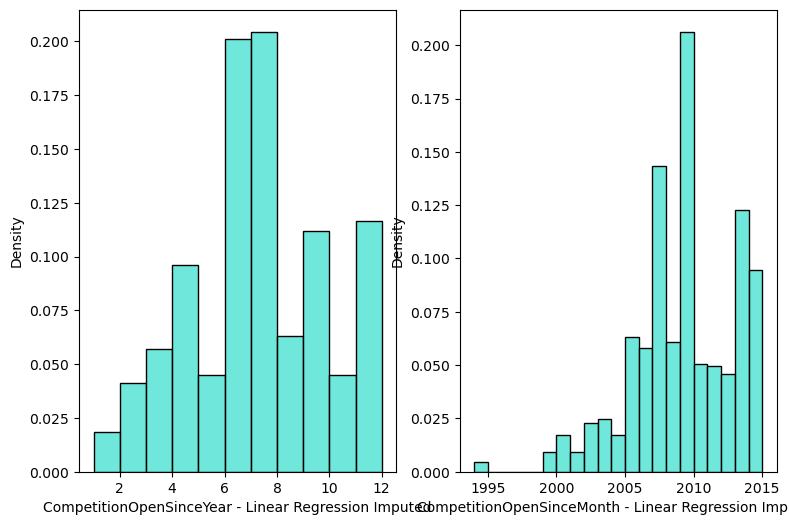

In [53]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(rossmann_reg, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[1].set_xlabel('CompetitionOpenSinceMonth - Linear Regression Imputed')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(rossmann_reg, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[0].set_xlabel('CompetitionOpenSinceYear - Linear Regression Imputed');

<hr>

**Observations:**

* `CompetitionOpenSinceYear` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.ionOpenSinceYear`

* `CompetitionOpenSinceMonth` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.


<hr>

#### **Forest Imputation**

In [56]:
rossmann_mice = rossmann[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales']].copy()
# Initialize Iterative Imputer with RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, random_state=0), random_state=0)

# Fit and transform data
imputed_data = imputer.fit_transform(rossmann_mice)

# Convert imputed data back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=rossmann_mice.columns)


In [57]:
kNN_model(imputed_df,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.650, precision 0.692, recall 0.650


<hr>

* Plot histogram

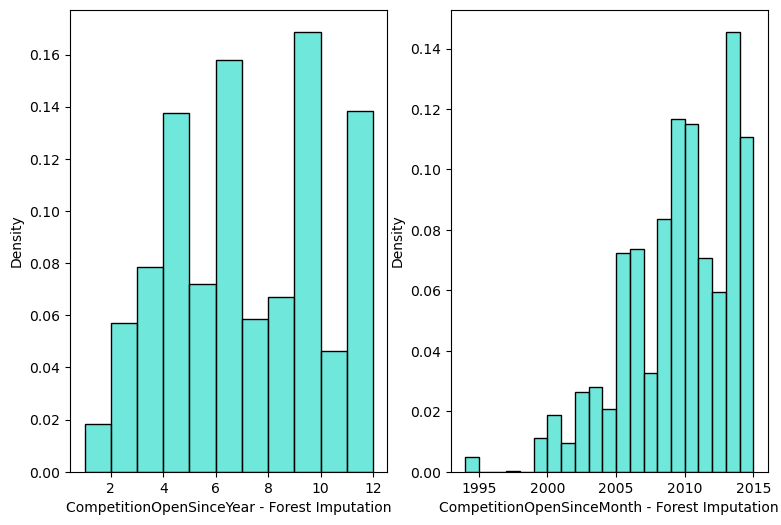

In [59]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(imputed_df, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[1].set_xlabel('CompetitionOpenSinceMonth - Forest Imputation')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(imputed_df, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[0].set_xlabel('CompetitionOpenSinceYear - Forest Imputation');

<hr>

**Observations:**

* We get alomsot the same histogram plot as in the KNN imputation method


<hr>

#### **Imputation conclusion**

* As observed in the `heatmap`, we found out that the columns with missing value, specifically `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` has a very weak correlation with other variables.
    * This suggests that these two feature variables has very minimal effect towards our target variable, the `Sales`.
* Hence, we will never get a perfect `bell shape` curve histogram for any of the imputation methods.

* The chosen imputation method is <u>KNN imputation</u>

### Time Series

In [66]:
rm_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205466 entries, 2015-07-31 to 2013-01-01
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      205466 non-null  int64  
 1   CompetitionDistance        205466 non-null  float64
 2   CompetitionOpenSinceMonth  205466 non-null  float64
 3   CompetitionOpenSinceYear   205466 non-null  float64
 4   Promo2                     205466 non-null  int64  
 5   Promo2SinceWeek            205466 non-null  float64
 6   Promo2SinceYear            205466 non-null  float64
 7   AverageSales               205466 non-null  float64
 8   DayOfWeek                  205466 non-null  int64  
 9   Sales                      205466 non-null  int64  
 10  Customers                  205466 non-null  int64  
 11  Open                       205466 non-null  int64  
 12  Promo                      205466 non-null  int64  
 13  SchoolHoliday

In [68]:
rm_imputed.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,AverageSales,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2Interval,StateHoliday,Promo2IntervalCat
Date,,,,,,,,,,,,,,,,,,,
2015-07-31,4,620.0,9.0,2009.0,0,0.0,0.0,8021.77,5,13995,1498,1,1,1,c,c,NA,0,0
2015-07-31,7,24000.0,4.0,2013.0,0,0.0,0.0,7356.90,5,15344,1414,1,1,1,a,c,NA,0,0
2015-07-31,24,4590.0,3.0,2000.0,1,40.0,2011.0,7763.77,5,14190,1082,1,1,1,a,c,"Jan,Apr,Jul,Oct",0,1
2015-07-31,25,430.0,4.0,2003.0,0,0.0,0.0,8892.31,5,14180,1586,1,1,1,c,a,NA,0,0
2015-07-31,27,60.0,1.0,2005.0,1,5.0,2011.0,7838.44,5,13213,1263,1,1,1,a,a,"Jan,Apr,Jul,Oct",0,1


Now, we can start data analysis.

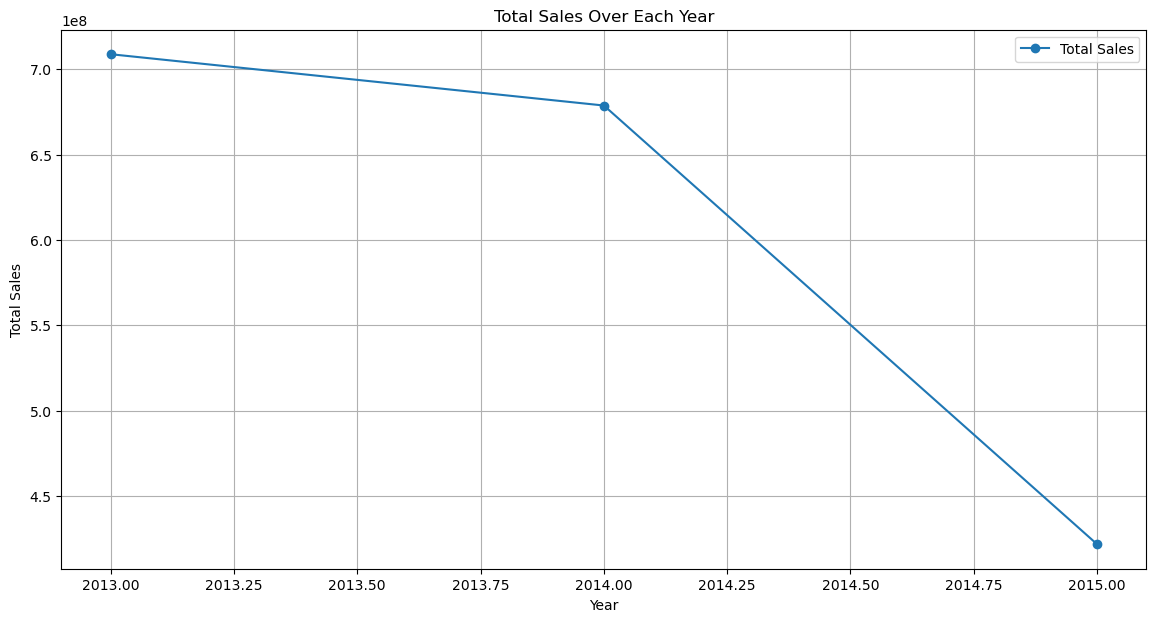

In [70]:
sales_year = rm_imputed['Sales'].resample('Y').sum()

# Plot the total sales over each year
plt.figure(figsize=(14, 7))
plt.plot(sales_year.index.year, sales_year, marker = 'o',label='Total Sales')
plt.title('Total Sales Over Each Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


From the above plot, we see that there is a clear decline in sales in the year 2014
So let's see what the total sales pattern is like in each month:

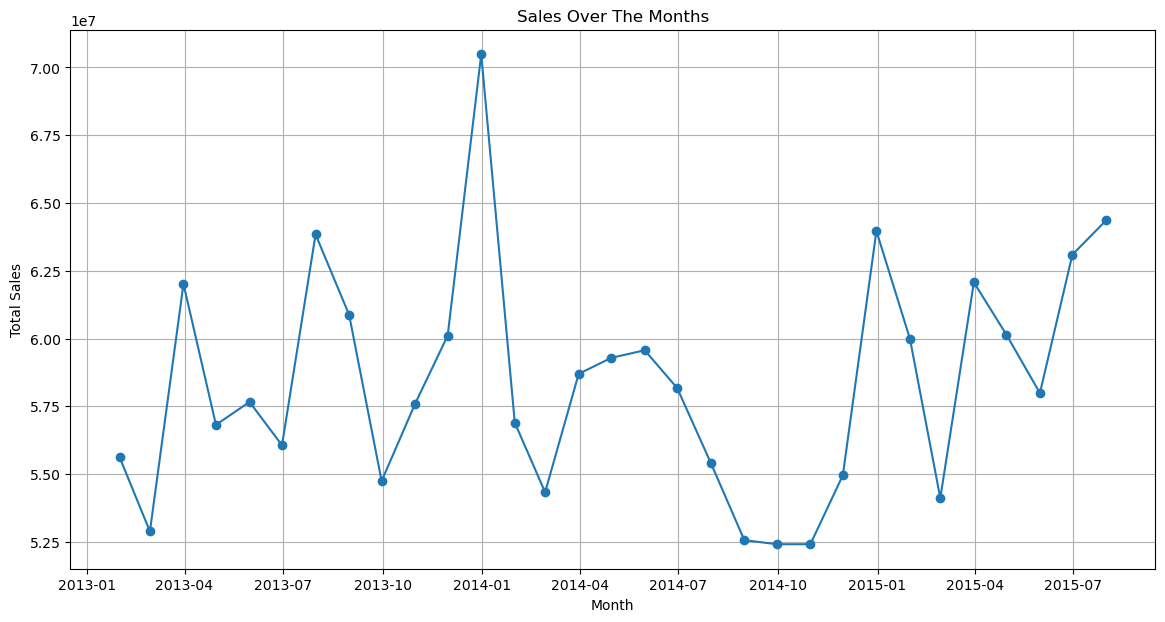

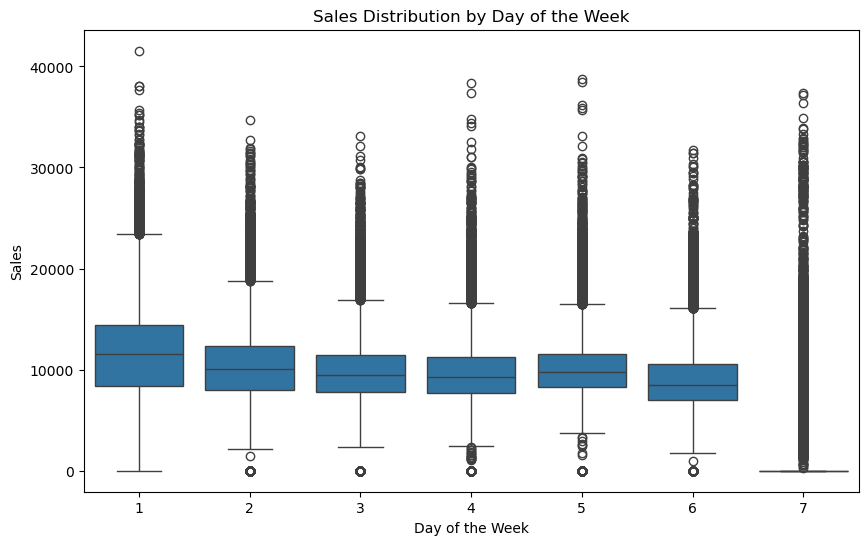

In [81]:
sales_monthly = rm_imputed['Sales'].resample('M').sum()

plt.figure(figsize=(14, 7))
plt.plot(sales_monthly.index, sales_monthly, marker='o', label='Monthly Sales')
plt.title('Sales Over The Months')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Sales', data=rossmann)
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()


There are a lot of fluctuations in sales throughout the years, but January of 2014 has the highest peak in sales. However, there is a decline in sales from then onwards till November 2014. After which sales increase again in January of 2015.

Additionally, the boxplot tells us the following points:
1) Monday (Day 1) has the highest median sales compared to the rest of the week. It also has a wider spread of sales values, as indicated by the length of the whiskers.
2) Saturday (Day 7) has the lowest median sales and the most extreme outliers, with several sales values far above the rest.
3) Tuesday to Friday (Days 2-6) have fairly consistent median sales and similar distributions. They all show a somewhat tight range of sales with a few outliers.
4) Outliers are present for each day, but they're especially noticeable on Monday and Saturday, suggesting that some stores or locations experience unusually high sales on these days.

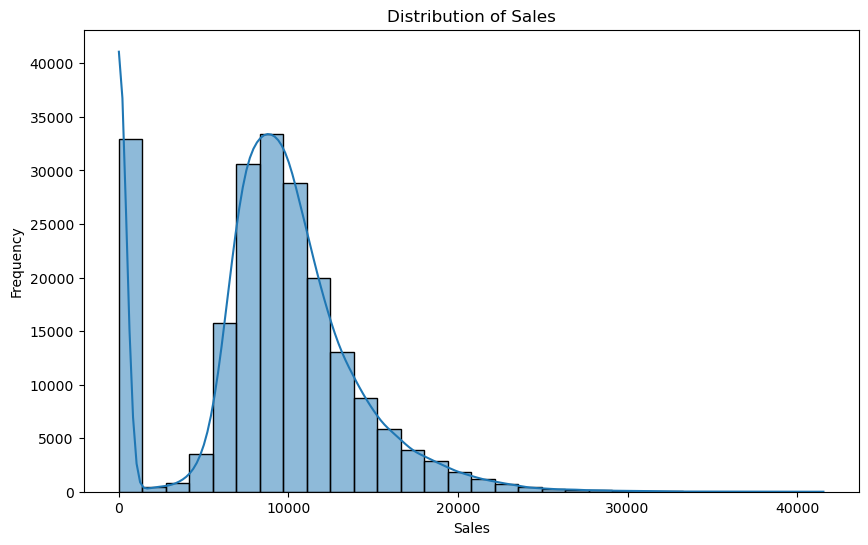

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(rm_imputed['Sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

Now let's look at the influence of promotion in sales

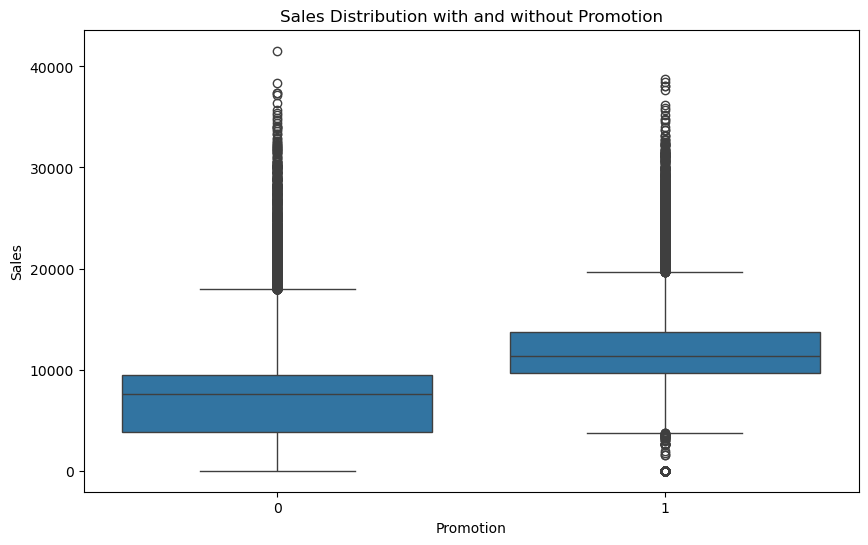

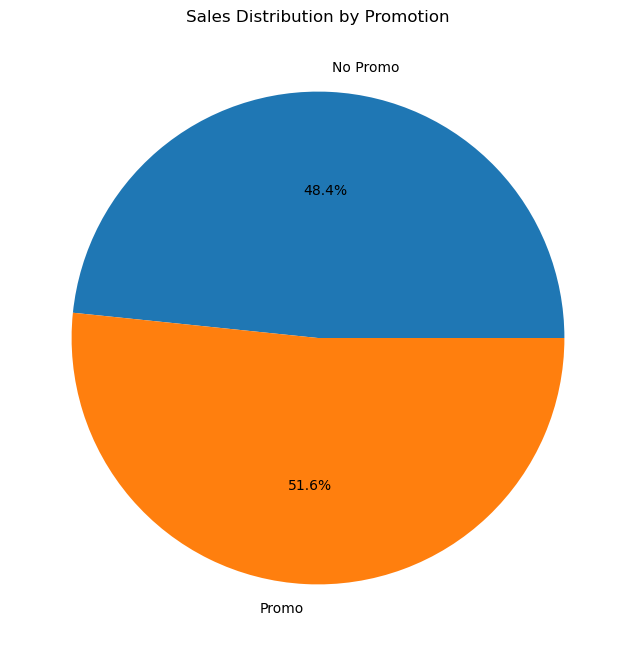

In [76]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data=rm_imputed)
plt.title('Sales Distribution with and without Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.show()

promo_sales = rm_imputed.groupby('Promo')['Sales'].sum()
plt.figure(figsize=(8, 8))
plt.pie(promo_sales, labels=['No Promo', 'Promo'],autopct='%1.1f%%')
plt.title('Sales Distribution by Promotion')
plt.show()


From the above graphs, it is clear that with promotion there is a slightly more increase in sales compared to without promotion

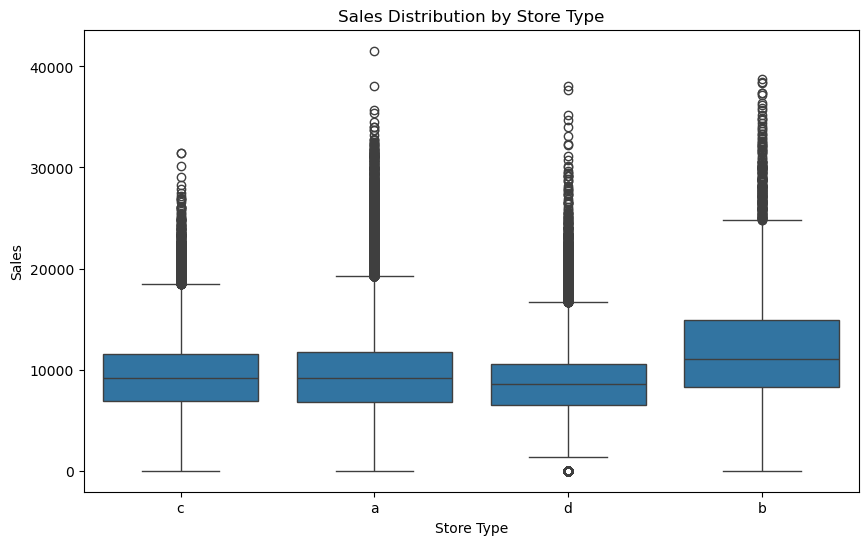

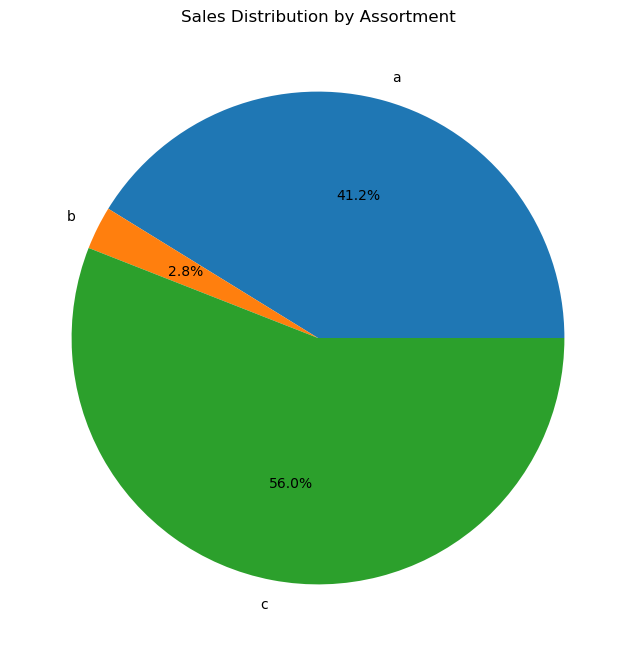

In [78]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='StoreType', y='Sales', data=rm_imputed)
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

assortment_sales = rm_imputed.groupby('Assortment')['Sales'].sum()
plt.figure(figsize=(8, 8))
plt.pie(assortment_sales, labels=assortment_sales.index, autopct='%1.1f%%')
plt.title('Sales Distribution by Assortment')
plt.show()


#### Multivariate Linear Regression

$$
Sales_{pred} = \text{intercept} + c_{\text{store}} \times \text{Store} + ... + c_{\text{Weekday}} \times \text{Weekday}
$$


Setting up **MLR model**

- `Sales` is our **target variable**.
- Aim is to predict `Sales` from other variables.

Here, we look at first few values of variables first and its descriptive statistics.

In [94]:
rm_imputed.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,AverageSales,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2Interval,StateHoliday,Promo2IntervalCat
Date,,,,,,,,,,,,,,,,,,,
2015-07-31,4,620.0,9.0,2009.0,0,0.0,0.0,8021.77,5,13995,1498,1,1,1,c,c,NA,0,0
2015-07-31,7,24000.0,4.0,2013.0,0,0.0,0.0,7356.90,5,15344,1414,1,1,1,a,c,NA,0,0
2015-07-31,24,4590.0,3.0,2000.0,1,40.0,2011.0,7763.77,5,14190,1082,1,1,1,a,c,"Jan,Apr,Jul,Oct",0,1
2015-07-31,25,430.0,4.0,2003.0,0,0.0,0.0,8892.31,5,14180,1586,1,1,1,c,a,NA,0,0
2015-07-31,27,60.0,1.0,2005.0,1,5.0,2011.0,7838.44,5,13213,1263,1,1,1,a,a,"Jan,Apr,Jul,Oct",0,1


In [95]:
rm_imputed.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,AverageSales,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Promo2IntervalCat
count,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000,205466.000000
mean,576.187603,5536.245997,6.923851,2009.099433,0.371789,9.450235,747.927657,8805.227176,3.998194,8805.227205,1009.707699,0.840115,0.381718,0.180458,0.557971
std,307.758776,9004.372374,3.208073,4.362555,0.483284,15.051344,972.221987,2199.417869,1.997380,5105.042705,690.499625,0.366501,0.485809,0.384569,0.859191
min,4.000000,40.000000,1.000000,1994.000000,0.000000,0.000000,0.000000,7016.020000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,342.000000,400.000000,4.000000,2006.000000,0.000000,0.000000,0.000000,7453.520000,2.000000,6808.000000,682.000000,1.000000,0.000000,0.000000,0.000000
50%,560.000000,1870.000000,7.000000,2010.000000,0.000000,0.000000,0.000000,7998.620000,4.000000,9080.000000,970.000000,1.000000,0.000000,0.000000,0.000000
75%,827.000000,5980.000000,9.000000,2013.000000,1.000000,14.000000,2011.000000,9156.410000,6.000000,11556.000000,1300.000000,1.000000,1.000000,0.000000,1.000000
max,1114.000000,75860.000000,12.000000,2015.000000,1.000000,48.000000,2015.000000,20718.520000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,3.000000


Observations:

- `Store`, `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `AverageSales`, `Customers` are continuous numerical data.
- `Promo2`, `DayOfWeek`, `Open`, `Promo`, `StateHoliday`, and `SchoolHoliday` are categorical data.
- Here we try to include all variables into our MLR first, then do feature selection to filter out unnecessary variables.

For categorical data, we try to manipulate it so that we could include them in our MLR model.
- `Promo2`, `Open`, `Promo` and `SchoolHoliday` are binary which consist only `0` and `1`, so we don't need to manipulate it.
- `DayOfWeek` is not binomial categorial data. We could have an interval of between 1 to 7 determining the "day of week"
- `StoreType` is not binomial categorial data. We could have stores between type `A` to `D` that determine the type of store.
- Similarly for `Assortment`, `Promo2Interval`, `StateHoliday`, which are not binomial categorical data, too.
- For these non-binomial categorical data, we would use `dummies` method in `Pandas` that separate them into columns of each data, that only consist eiter `0` or `1`, indicating `False` or `True`.

In [96]:
# Initialise a function since we will be using it nultiple times
def create_dummies(df, column_name, rename_dict):
    dummies = (pd.get_dummies(df[column_name], dtype=int)
              .rename(columns=rename_dict)
              )
    return dummies

In [97]:
dummies_DayOfWeek = create_dummies(rm_imputed, 'DayOfWeek', {
                                    1: 'Monday', 
                                    2: 'Tuesday', 
                                    3: 'Wednesday', 
                                    4: 'Thursday', 
                                    5: 'Friday', 
                                    6: 'Saturday', 
                                    7: 'Sunday'})

dummies_Store_Type = create_dummies(rm_imputed, 'StoreType', {
                                    "a": "StoreTypeA", 
                                    "b": "StoreTypeB", 
                                    "c": "StoreTypeC",
                                    "d": "StoreTypeD"})

dummies_Assortment = create_dummies(rm_imputed, 'Assortment', {
                                    "a": "AssortmentA", 
                                    "b": "AssortmentB", 
                                    "c": "AssortmentC"})

dummies_Promo2Interval = (create_dummies(rm_imputed, 'Promo2Interval', {
                                        "Jan,Apr,Jul,Oct": "Promo2_Int_TypeA", 
                                        "Feb,May,Aug,Nov": "Promo2_Int_TypeB", 
                                        "Mar,Jun,Sept,Dec": "Promo2_Int_TypeC"})
                          .drop(columns=["NA"]))
                        # we doesn't need any of NA as 0 for these 3 cols could represent no promo dy

dummies_StateHoliday = (create_dummies(rm_imputed, 'StateHoliday', {
                                        "a": "PublicHoliday", 
                                        "b": "EasterHoliday", 
                                        "c": "Christmas"})
                            .drop(columns=['0',0])) 
                        # in the original dataset, both int(0), and str(0) are stored for indication of "no holiday"
                        # we doesn't need any of these as 0 for "a", "b", and "c" could represent a "no holiday" dy

Here we instantiate a df for MLR model that consist **all** manipulated columns in it. 

In [98]:
rm_mlr_df = (pd.concat([rm_imputed, dummies_DayOfWeek, dummies_Store_Type, dummies_Assortment, dummies_Promo2Interval, dummies_StateHoliday], axis=1)
             .drop(columns=["StoreType","DayOfWeek","Assortment","Promo2Interval","StateHoliday"]))

Navigating the correlations:

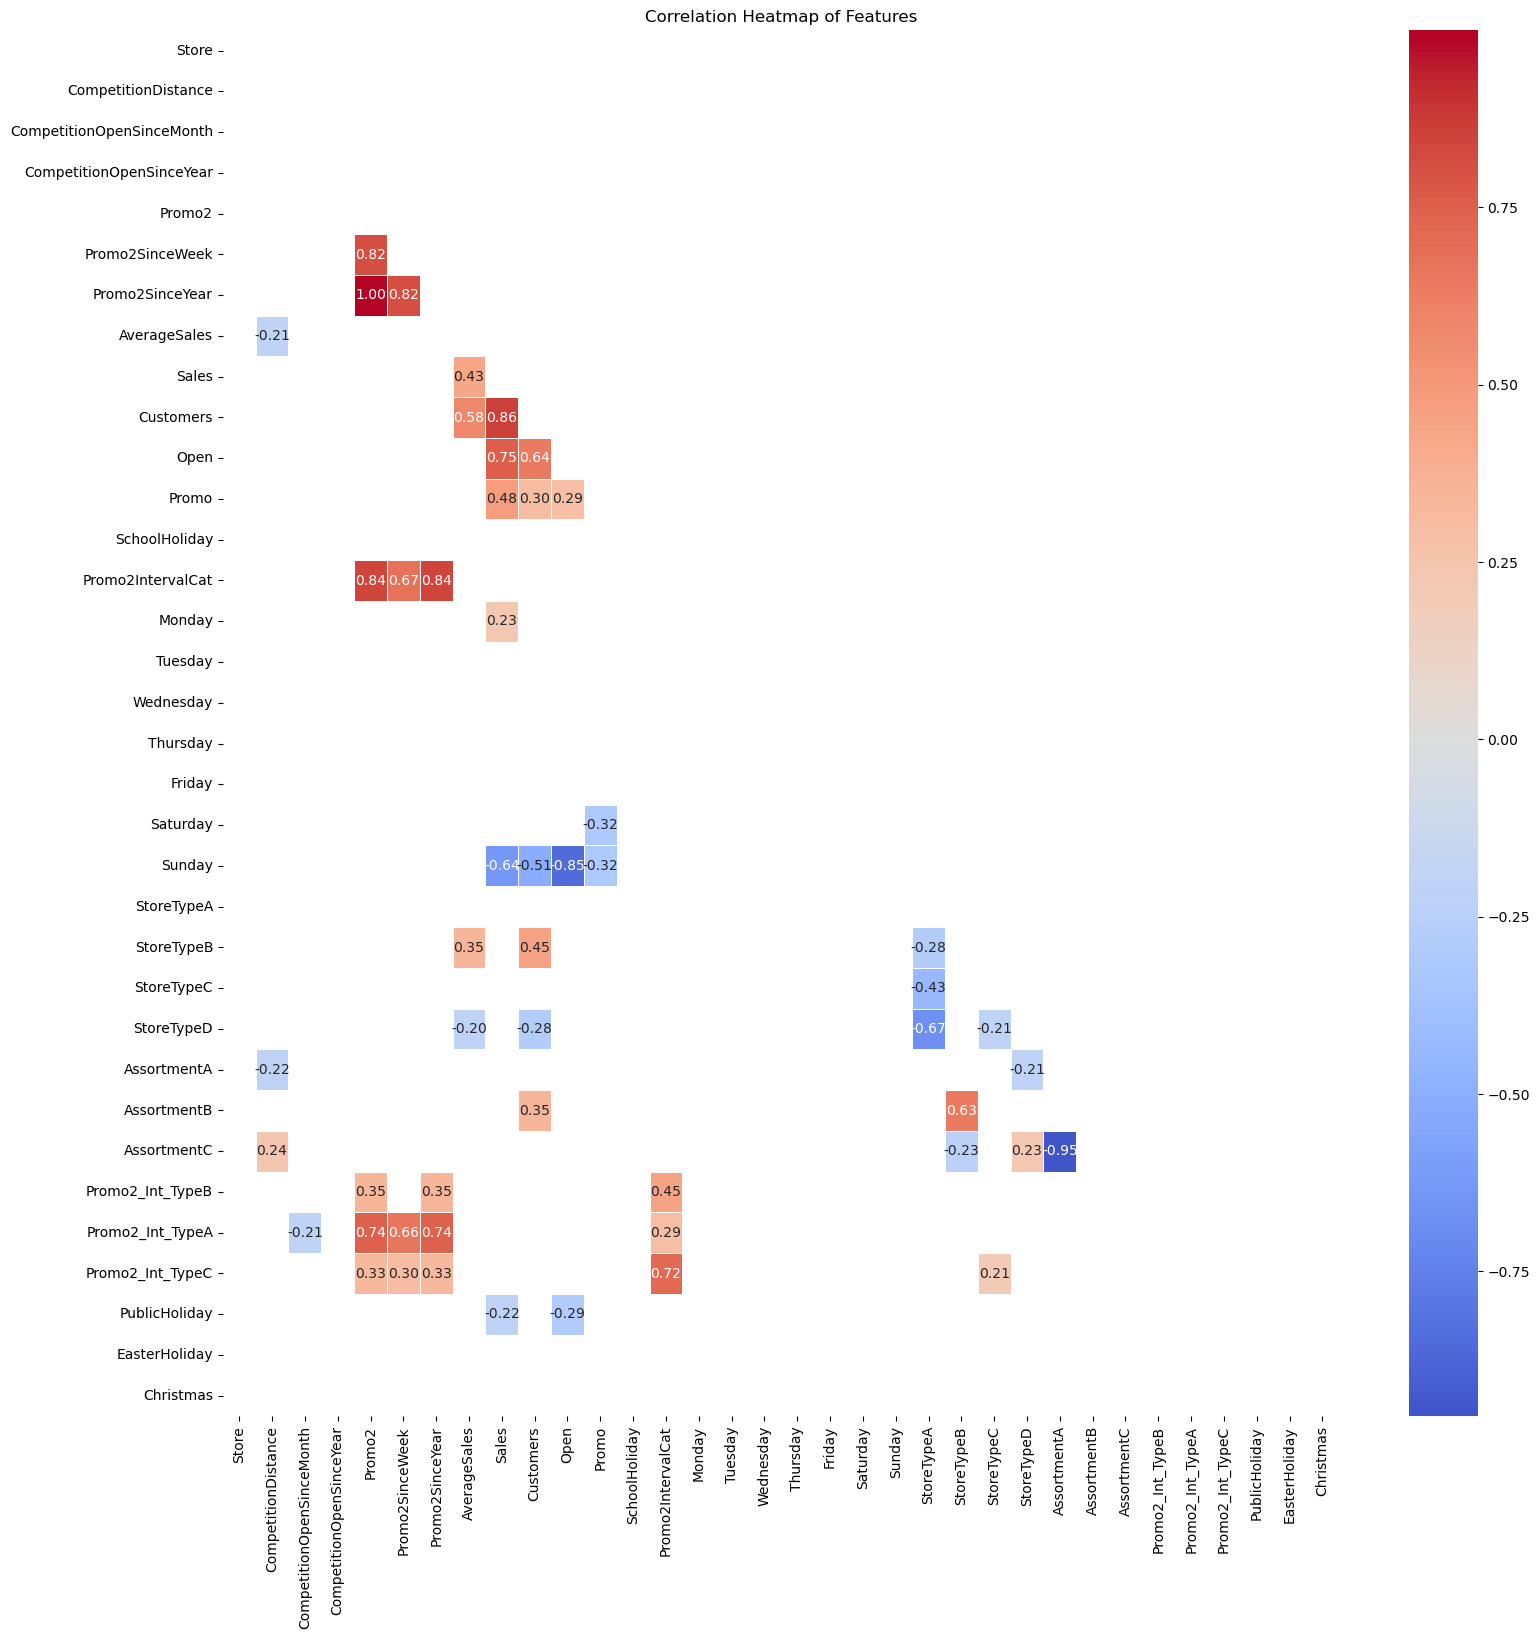

In [99]:
corrs = rm_mlr_df.corr()

# Filter out correlations lower than 0.3 by replacing them with NaN
filtered_corrs = corrs.where(np.abs(corrs) >= 0.2)
#filtered_corrs = corrs 

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_corrs, dtype=bool))

# Create the heatmap with the filtered correlations and mask
plt.figure(figsize=(18, 18))
sns.heatmap(filtered_corrs, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, cbar=True, mask=mask)

plt.title('Correlation Heatmap of Features')
plt.show()


Although this would cause a complex model, but as our first approach, we will still make a model directly using all variables and look at the result of accuracy.

In [100]:
def MLR_regression_training(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2,
    ) 
    # Construct and fit the model
    linear = LinearRegression() 
    linear.fit(X_train,Y_train)  

    # Evaluate model performance.
    training_predictions = linear.predict(X_train)  
    testing_predictions = linear.predict(X_test)    

    # Create a table of the various scores.
    table = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    
    return table

In [101]:
X = rm_mlr_df.drop(["Sales"],axis=1)
Y = rm_mlr_df['Sales']   
MLR_regression_training(X, Y)

,R^2,RMSE,MAE
train,0.915155,1485.689199,1090.713371
test,0.912853,1512.342922,1101.686058


According to the result above, the model seem to be overfitted much. This may because of this model is taking account in noise (e.g: assortment) rather than important variables. 

Thus, feature selections should be done.

**Feature selections**

We take in account of variables that have correlation (correlation > 0.4) to `sales`

The variables that fulfil the requirement are:
- `Promo`
- `Open`
- `Customers`

In [102]:
X = rm_mlr_df[["Promo","Open","Customers"]] 
Y = rm_mlr_df['Sales']   
MLR_regression_training(X, Y)

,R^2,RMSE,MAE
train,0.849694,1981.269779,1314.662835
test,0.847089,1987.812441,1320.557502


Ok we are cooked 🔥

Then now what else?

do again feature selection???? 

We have to see which of them are suitable, as there are slighly some correlation between each of them, that:
- `Promo` and `Open`: It could be have Promo if and only if it's open.
- `Open` and `Customers`: It could be have Customers if and only if it's open.
- `Promo` and `Customers`: Some customers might be coming if there is promo.

To further investigate the multicolinearity, we would use **lasso regression** as:
- Feature Selection is Important: 

In [103]:
# Calculate the absolute correlation with the target variable 'Sales'
correlations = abs(rm_mlr_df.corr()['Sales'])

# Select features with correlation >= 0.3 and drop 'Sales'
selected_features = (correlations[correlations > 0.2]
                     .index
                     .drop("Sales"))

# Define X and Y
X = rm_mlr_df[selected_features]  # Selecting the columns
y = rm_mlr_df['Sales']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Hyperparameter Tuning for Lasso
alphas = np.logspace(-4, 1, 50)
lasso_cv_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    lasso_cv_scores.append(np.mean(scores))

# Find the optimal alpha
optimal_alpha_lasso = alphas[np.argmax(lasso_cv_scores)]
print(f"Optimal alpha for Lasso: {optimal_alpha_lasso:.4f}")


Optimal alpha for Lasso: 0.0043


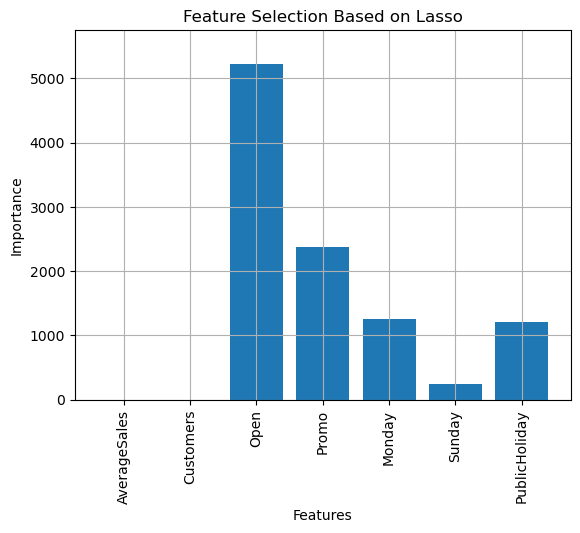

In [104]:
# Fit Lasso with the optimal alpha
lasso1 = Lasso(alpha=optimal_alpha_lasso)
lasso1.fit(X_train, y_train)

# Get feature names
names = X.columns  # This should be ["Promo", "Open", "Customers"]

# Get the absolute values of coefficients
lasso1_coef = np.abs(lasso1.coef_)

# Plotting
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, max(lasso1_coef)*1.1)
plt.show()

As both `Open` and `Promo` appeared to be the most important features here, we would choose both of them as out targeted variable, and further do normalisation。

In [105]:
rm_mlr_df = rm_mlr_df[["Open", "Promo", "Customers", "Sales"]]
X = rm_mlr_df.drop("Sales", axis = 1)
y = rm_mlr_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2,
    random_state=np.random.RandomState(31287)  # Keeps the 'random' split consistent.
) 

# Construct and fit the model
linear = LinearRegression()  # Instantatiate the linear regression model
linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.

# Evaluate model performance.
training_predictions = linear.predict(X_train)  # Get model predictions for both.
testing_predictions = linear.predict(X_test)    # training and testing data.

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.849283,1981.597245,1314.785578
test,0.848756,1986.519776,1319.569546


In [108]:
feature_names = X.columns.tolist() # write the column names to a list

# create a Series for which the rows are the feature names and the data is 
# the regression coefficient values
coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)
coefficients

Open         4305.219638
Promo        2192.239000
Customers       4.445031
dtype: float64

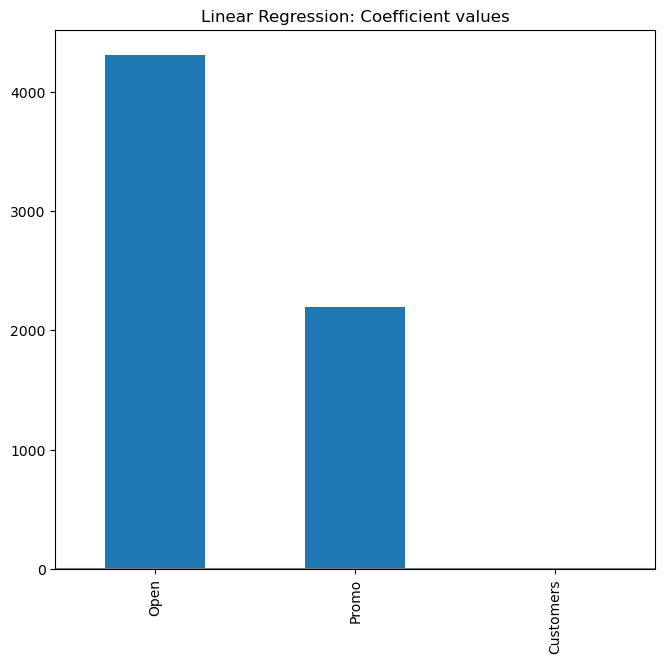

In [109]:
coefficients.plot(kind='bar', figsize=(10, 7)) 
plt.title('Linear Regression: Coefficient values') 
plt.axhline(y=0, color='.5') 
plt.subplots_adjust(left=.3) 

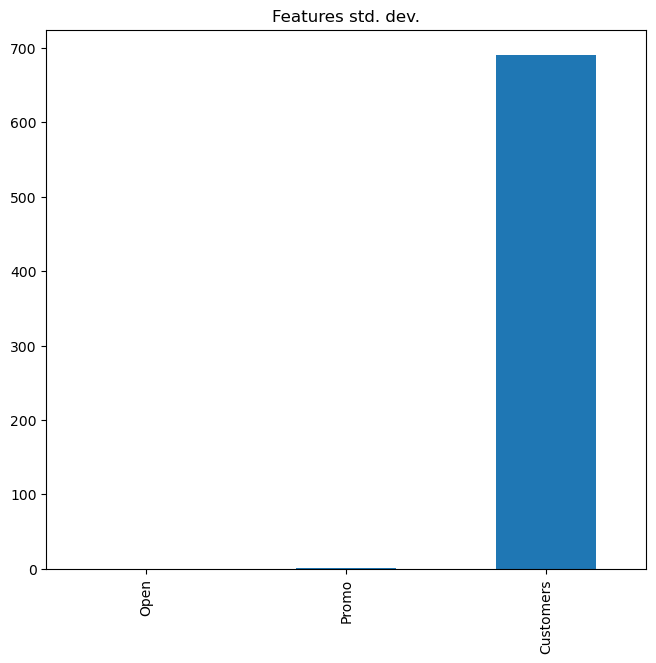

In [110]:
X_train.std(axis=0).plot(kind='bar', figsize=(10, 7)) 
plt.title('Features std. dev.') 
plt.subplots_adjust(left=.3)

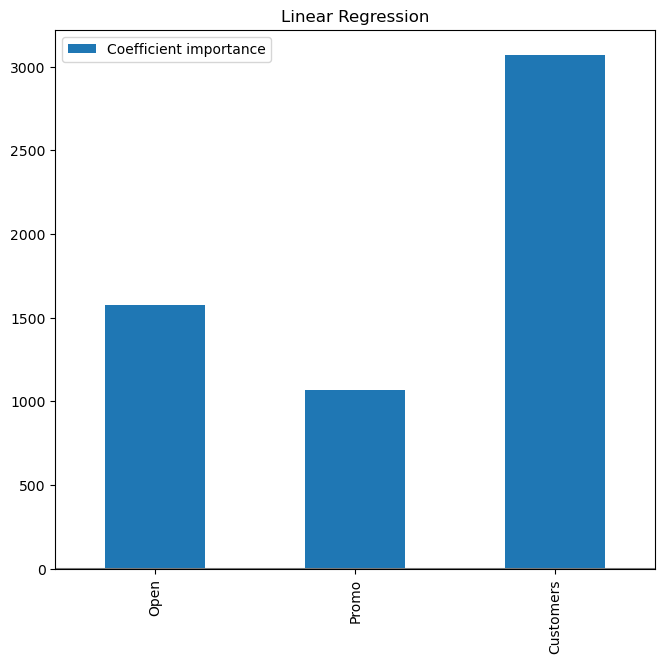

In [111]:
coefs = pd.DataFrame(
    linear.coef_ * X_train.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)
# do a similar plot of this variable, as above
coefs.plot(kind='bar', figsize=(10, 7))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

In [112]:
nX =(X-X.mean())/X.std() # create nX, a normalised version of X
nX.describe() 

,Open,Promo,Customers
count,2.054660e+05,2.054660e+05,2.054660e+05
mean,6.667412e-17,-2.545236e-17,8.424178e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.292260e+00,-7.857360e-01,-1.462286e+00
25%,4.362485e-01,-7.857360e-01,-4.745950e-01
50%,4.362485e-01,-7.857360e-01,-5.750575e-02
75%,4.362485e-01,1.272686e+00,4.204091e-01
max,4.362485e-01,1.272686e+00,9.237213e+00


In [113]:
# substituting nX for X in train_test_split, to use our normalised data.

# Split into a training set with 80% of the data, and a testing set as the remainder.
X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y, test_size=0.2,
) 

# Construct and fit the model
linear = LinearRegression()  
linear.fit(X_train,Y_train)  

# Evaluate model performance.
training_predictions = linear.predict(X_train)  
testing_predictions = linear.predict(X_test)    

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.849832,1980.148185,1313.687041
test,0.846535,1992.282463,1323.165544


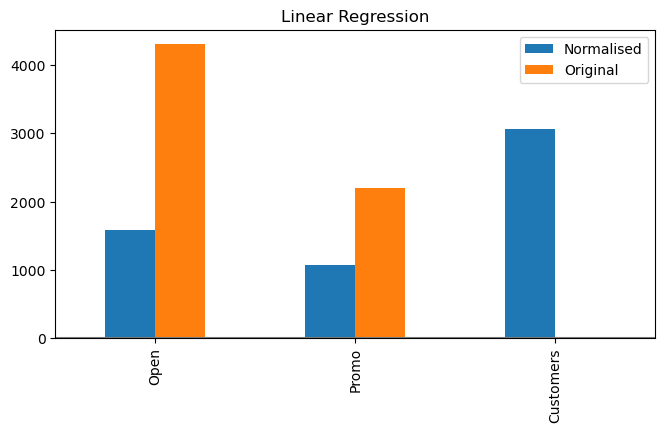

In [114]:
# create a new dataframe with the regression coefficients from the normalised data
normed_coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)

# add our original coefficient importance to this dataframe
all_coefficients = pd.DataFrame({
    'Normalised': normed_coefficients,
    'Original': coefficients,
})

# do a similar horizontal plot as before
ax = all_coefficients.plot(kind='bar',figsize=(10,4))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

In [115]:
feature_names = X.columns.tolist() # write the column names to a list

# create a Series for which the rows are the feature names and the data is 
# the regression coefficient values
coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)
coefficients

Open         1578.885042
Promo        1061.991015
Customers    3068.441773
dtype: float64

In [116]:
MLR_regression_training(nX, Y)

,R^2,RMSE,MAE
train,0.848632,1983.697764,1316.276128
test,0.851335,1978.102513,1315.161268


Coefficients: [1581.78866832 1065.77154617 3062.65018144]
Intercept: 8807.128119247529
Mean Squared Error: 3886632.9372580973
R-squared: 0.8502958619986605
            Actual Price  Predicted Price
Date                                     
2014-01-31         18178     14387.192723
2014-10-07         11947     11591.155152
2014-07-23         11248     10279.991404
2013-09-20          7512      7973.571657
2013-05-24          7830      9082.427305
...                  ...              ...
2014-01-16          7614      8798.560259
2013-06-02             0      -134.649334
2013-11-29         12804      9916.286752
2013-02-01          9761      9876.367949
2014-04-16         17040     15294.733016

[61640 rows x 2 columns]


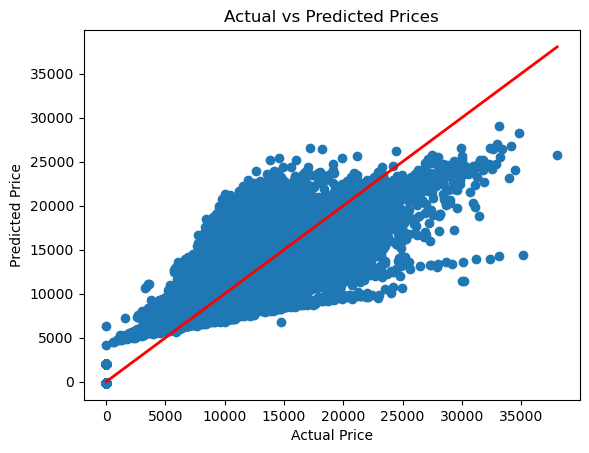

In [117]:
X = rm_mlr_df.drop(["Sales"],axis=1)
Y = rm_mlr_df['Sales']   

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the prices for the test set
y_pred = model.predict(X_test)

# Print the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Show the actual vs predicted prices
comparison = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print(comparison)


# Plotting Actual vs Predicted Prices
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Perfect prediction line
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()